## Data Engineering

In [1]:
import os
import findspark
findspark.init()
findspark.find()
from pyspark.sql.functions import lit
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.types import FloatType,IntegerType
from pyspark.sql.functions import *

In [2]:
# connect spark to PostgreSQL
appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
#
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master) 

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\Spark\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="200042"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['table']="fifa"
db_properties['driver']="org.postgresql.Driver"
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)
df_read.printSchema()

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24           
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [4]:
df=df_read

In [5]:
#here comes a problem,['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 
#'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk'] actually should not be category_features
#We need to change each of this into two columns,which are 'potential' and 'original'
columns_modify=['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

In [6]:
def get_potential_udf(value):
    operator_pos1 = value.find('+')
    operator_pos2 = value.find('-')
    
    if operator_pos1 != -1:
        result = int(value[:operator_pos1]) + int(value[operator_pos1+1:]) 
    elif operator_pos2 != -1:
        result = int(value[:operator_pos2]) - int(value[operator_pos2+1:])
    else:
        result = int(value)  

    return result

def get_original_udf(value):
    operator_pos1 = value.find('+')
    operator_pos2 = value.find('-')
    
    if operator_pos1 != -1:
        result = int(value[:operator_pos1])
    elif operator_pos2 != -1:
        result = int(value[:operator_pos2])
    else:
        result = int(value)  

    return result

In [7]:
get_potential = udf(get_potential_udf, IntegerType())
get_original = udf(get_original_udf,IntegerType())

In [8]:
for column in columns_modify:
    column_potential=f'{column}_potential'
    column_original=f'{column}_original'
    df = df.withColumn(column_potential, get_potential(col(column)))
    df =df.withColumn(column_original,get_original(col(column))).drop(column)  

In [9]:
string_features=[feature[0] for feature in df.dtypes if feature[1] in ('string')]
print(string_features)

['player_url', 'short_name', 'long_name', 'player_positions', 'club_name', 'league_name', 'club_position', 'club_loaned_from', 'nationality_name', 'nation_position', 'preferred_foot', 'work_rate', 'body_type', 'real_face', 'player_tags', 'player_traits', 'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 'nation_flag_url']


In [10]:
#drop all string_features
#Because these nominal features will increase the burden of memory and don't really play an important role in prediction.
for col in string_features:
    df=df.drop(col)

In [11]:
#drop 'dob' beacuase we already have 'age'
# In adiition, 'dob' and 'club_joined' are date column
df=df.drop('dob','club_joined')
#'sofifa_id' should be dropped, because id should not be an index for predicting overall value
df=df.drop('sofifa_id')

In [12]:
def get_null(df):
    null_counts_df = df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns])

    first_row_dict = null_counts_df.first().asDict()

    filtered_data = {key: value for key, value in first_row_dict.items() if value != 0}
    return filtered_data

In [13]:
# I don't know why if I don't import repeatedly, there will be an error occured
from pyspark.sql.functions import *
null_columns=get_null(df)
null_columns

{'value_eur': 1897,
 'wage_eur': 1622,
 'club_team_id': 1630,
 'league_level': 2015,
 'club_jersey_number': 1630,
 'club_contract_valid_until': 1630,
 'nation_team_id': 133635,
 'nation_jersey_number': 133635,
 'release_clause_eur': 55582,
 'pace': 15791,
 'shooting': 15791,
 'passing': 15791,
 'dribbling': 15791,
 'defending': 15791,
 'physic': 15791,
 'mentality_composure': 31778,
 'goalkeeping_speed': 126288}

In [14]:
#drop columns that have more than half null values
#'release_clause_eur' also need to be dropped, although it has less than half null values
#We can see from above that, all goalkeepers don't have 'pace','shooting','passing','dribbling','defending'
#And all players who are not goalkeeper don't have 'goalkeeping_speed'
#In this case, I believe we should not drop  'goalkeeping_speed' because it's a very important index for goalkeepers.
df=df.drop('release_clause_eur','nation_team_id','nation_jersey_number')

In [15]:
from pyspark.sql.functions import *
null_columns=get_null(df)
null_columns

{'value_eur': 1897,
 'wage_eur': 1622,
 'club_team_id': 1630,
 'league_level': 2015,
 'club_jersey_number': 1630,
 'club_contract_valid_until': 1630,
 'pace': 15791,
 'shooting': 15791,
 'passing': 15791,
 'dribbling': 15791,
 'defending': 15791,
 'physic': 15791,
 'mentality_composure': 31778,
 'goalkeeping_speed': 126288}

In [16]:
# These features are missing for those players who are not in a club
# It's only a very small number, so we drop those rows.
df=df.na.drop(subset=["value_eur",'wage_eur', 'club_team_id','league_level','club_jersey_number','club_contract_valid_until'])

In [17]:
from pyspark.sql.functions import *
null_columns=get_null(df)
null_columns

{'pace': 15502,
 'shooting': 15502,
 'passing': 15502,
 'dribbling': 15502,
 'defending': 15502,
 'physic': 15502,
 'mentality_composure': 31226,
 'goalkeeping_speed': 124287}

In [18]:
# imputation for 'pace','shooting','passing','dribbling','defending','physic','mentality_composure','goalkeeping_speed'
# When it comes to numeric featurs，
# we can transform numeric features that are None into median of that feature
from pyspark.ml.feature import Imputer

imputed_cols=['pace','shooting','passing','dribbling','defending','physic','mentality_composure','goalkeeping_speed']

imputer = Imputer (
            inputCols=imputed_cols,
            outputCols=["{}_imputed".format(c) for c in imputed_cols])\
            .setStrategy("median").setMissingValue(None)

df_imputed = imputer.fit(df).transform(df)

# drop and rename new column as original column names
for col in imputed_cols:
    df_imputed = df_imputed.drop(col)
    df_imputed = df_imputed.withColumnRenamed("{}_imputed".format(col),col)
df=df_imputed

In [19]:
from pyspark.sql.functions import *
null_columns=get_null(df)
null_columns

{}

In [20]:
# from my perspective, club_contract_valid_until-year=club_contract_valid_last is better
df=df.withColumn('club_contract_valid_last',col('club_contract_valid_until')-col('year')).drop('club_contract_valid_until').drop('year')

In [21]:
df.columns

['overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'league_level',
 'club_jersey_number',
 'nationality_id',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_r

In [22]:
numeric_features = [feature[0] for feature in df.dtypes if feature[1] in ('int','float')]
print(numeric_features)
category_features= [feature[0] for feature in df.dtypes if feature[1] not in ('int','float','timestamp')]
print(category_features)

['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'league_level', 'club_jersey_number', 'nationality_id', 'weak_foot', 'skill_moves', 'international_reputation', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls_potential', 'ls_original', 'st_p

## Spark Pipeline

In [23]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'league_level',
             'club_jersey_number', 'nationality_id', 'weak_foot', 'skill_moves', 'international_reputation', 'attacking_crossing',
             'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
             'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration',
             'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power',
             'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
             'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle',
             'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
             'goalkeeping_reflexes', 'ls_potential', 'ls_original', 'st_potential', 'st_original', 'rs_potential', 'rs_original',
             'lw_potential', 'lw_original', 'lf_potential', 'lf_original', 'cf_potential', 'cf_original', 'rf_potential', 'rf_original',
             'rw_potential', 'rw_original', 'lam_potential', 'lam_original', 'cam_potential', 'cam_original', 'ram_potential',
             'ram_original', 'lm_potential', 'lm_original', 'lcm_potential', 'lcm_original', 'cm_potential', 'cm_original',
             'rcm_potential', 'rcm_original', 'rm_potential', 'rm_original', 'lwb_potential', 'lwb_original', 'ldm_potential',
             'ldm_original', 'cdm_potential', 'cdm_original', 'rdm_potential', 'rdm_original', 'rwb_potential', 'rwb_original', 
             'lb_potential', 'lb_original', 'lcb_potential', 'lcb_original', 'cb_potential', 'cb_original', 'rcb_potential', 
             'rcb_original', 'rb_potential', 'rb_original', 'gk_potential', 'gk_original', 'pace', 'shooting', 'passing',
             'dribbling', 'defending', 'physic', 'mentality_composure', 'goalkeeping_speed', 'club_contract_valid_last']

#we don't have nominal_cols or binary cols here
nominal_cols = []

#'value_eur' should not be included, because it's outcome
continuous_cols =['overall', 'potential', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'league_level',
             'club_jersey_number', 'nationality_id', 'weak_foot', 'skill_moves', 'international_reputation', 'attacking_crossing',
             'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
             'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration',
             'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power',
             'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
             'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle',
             'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
             'goalkeeping_reflexes', 'ls_potential', 'ls_original', 'st_potential', 'st_original', 'rs_potential', 'rs_original',
             'lw_potential', 'lw_original', 'lf_potential', 'lf_original', 'cf_potential', 'cf_original', 'rf_potential', 'rf_original',
             'rw_potential', 'rw_original', 'lam_potential', 'lam_original', 'cam_potential', 'cam_original', 'ram_potential',
             'ram_original', 'lm_potential', 'lm_original', 'lcm_potential', 'lcm_original', 'cm_potential', 'cm_original',
             'rcm_potential', 'rcm_original', 'rm_potential', 'rm_original', 'lwb_potential', 'lwb_original', 'ldm_potential',
             'ldm_original', 'cdm_potential', 'cdm_original', 'rdm_potential', 'rdm_original', 'rwb_potential', 'rwb_original', 
             'lb_potential', 'lb_original', 'lcb_potential', 'lcb_original', 'cb_potential', 'cb_original', 'rcb_potential', 
             'rcb_original', 'rb_potential', 'rb_original', 'gk_potential', 'gk_original', 'pace', 'shooting', 'passing',
             'dribbling', 'defending', 'physic', 'mentality_composure', 'goalkeeping_speed', 'club_contract_valid_last']

drop1_cols=['player_url', 'short_name', 'long_name', 'player_positions', 'club_name', 'league_name', 'club_position',
            'club_loaned_from', 'nationality_name', 'nation_position', 'preferred_foot', 'work_rate', 'body_type', 
            'real_face', 'player_tags', 'player_traits', 'player_face_url', 'club_logo_url', 'club_flag_url', 'nation_logo_url', 
            'nation_flag_url','dob','club_joined','sofifa_id','release_clause_eur','nation_team_id','nation_jersey_number']

drop_na_cols=["value_eur",'wage_eur', 'club_team_id','league_level','club_jersey_number','club_contract_valid_until']

imputed_cols=['pace','shooting','passing','dribbling','defending','physic','mentality_composure','goalkeeping_speed']

modify_cols=['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm',
                'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb','cb', 'rcb', 'rb', 'gk']


class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df=dataset
        output_df = output_df.withColumn('outcome', col('value_eur').cast(DoubleType())).drop('value_eur')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col in self.columns_to_drop:
            output_df = output_df.drop(col)
        return output_df

class NaDropper(Transformer):
    def __init__(self, columns_to_dropna = None):
        super().__init__()
        self.columns_to_dropna=columns_to_dropna
    def _transform(self, dataset):
        output_df = dataset
        output_df = output_df.na.drop(subset=self.columns_to_dropna)
        return output_df

class Imputation(Transformer):
    def __init__(self, imputed_cols = None):
        super().__init__()
        self.imputed_cols=imputed_cols
    def _transform(self, dataset):
        imputer = Imputer (
                    inputCols=self.imputed_cols,
                    outputCols=["{}_imputed".format(c) for c in self.imputed_cols])\
                    .setStrategy("median").setMissingValue(None)
        output_df = dataset
        output_df = imputer.fit(output_df).transform(output_df)
        for col in self.imputed_cols:
            output_df = output_df.drop(col)
            output_df = output_df.withColumnRenamed("{}_imputed".format(col),col)
        return output_df

class Modifier(Transformer):
    def __init__(self, modify_cols = None):
        super().__init__()
        self.modify_cols=modify_cols
    def _transform(self, dataset):
        output_df = dataset
        for column in self.modify_cols:
            column_potential=f'{column}_potential'
            column_original=f'{column}_original'
            output_df = output_df.withColumn(column_potential, get_potential(col(column)))
            output_df =output_df.withColumn(column_original,get_original(col(column))).drop(column)   
        return output_df



class GetClubContractValidLast(Transformer):
    def __init__(self, modify_cols = None):
        super().__init__()
    def _transform(self, dataset):
        output_df = dataset
        output_df=output_df.withColumn('club_contract_valid_last',col('club_contract_valid_until')-col('year')).drop('club_contract_valid_until').drop('year')
        return output_df
    
def get_preprocess_pipeline():
    
    stage_column_dropper1 = ColumnDropper(columns_to_drop = drop1_cols)
    
    stage_column_dropper2=NaDropper(columns_to_dropna=drop_na_cols)
    
    stage_imputation=Imputation(imputed_cols)
    
    stage_column_modify1=Modifier(modify_cols)
    
    stage_column_modify2=GetClubContractValidLast()
    
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    
#     #We don't have nominal features here
#     stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols,handleInvalid='keep' )

#     # Stage where the index columns are further transformed using OneHotEncoder
#     stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols
    
#     corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
#                      "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
#     for col_name in corelated_cols_to_remove:
#         feature_cols.remove(col_name)

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper3 = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+  continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_column_dropper1,stage_column_dropper2,stage_imputation,stage_column_modify1,stage_column_modify2,\
                                stage_typecaster,stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper3])
    return pipeline 

In [24]:
df_raw=sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()
df_raw.count()

142079

In [25]:
# split dataset into train,test dataset by order
total_rows = df_raw.count()

split_point = int(total_rows * 0.8)

train_df_raw = df_raw.limit(split_point)
test_df_raw = df_raw.subtract(train_df_raw)

# # 使用randomSplit方法划分train dataset和test dataset
# weights = [0.8,0.2]

# train_df_raw, test_df_raw= train_df_raw.randomSplit(weights, seed=42)
print(train_df_raw.count(),test_df_raw.count())

113663 28416


In [26]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train_df_raw)

train_df = preprocess_pipeline_model.transform(train_df_raw)
test_df = preprocess_pipeline_model.transform(test_df_raw)

In [27]:
pdf=train_df.toPandas()
pdf

,features,outcome
0,"[13.10387599928444, 15.017210893685483, 23.484...",100500000.0
1,"[12.962974106819017, 14.54298318125331, 16.011...",79000000.0
2,"[12.681170321888168, 14.226831372965195, 11.74...",54500000.0
3,"[12.681170321888168, 14.226831372965195, 11.74...",52500000.0
4,"[12.681170321888168, 14.226831372965195, 12.80...",63500000.0
...,...,...
111497,"[9.158623010252565, 10.749161481795925, 0.0426...",800000.0
111498,"[9.158623010252565, 10.43300967350781, 0.08539...",825000.0
111499,"[9.158623010252565, 10.43300967350781, 0.12809...",825000.0
111500,"[9.158623010252565, 10.274933769363752, 0.2561...",725000.0


## Spark Models

### GBT

In [28]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [29]:
gbt = GBTRegressor(featuresCol="features", labelCol="outcome", maxIter=10)
gbt_model = gbt.fit(train_df)

In [30]:
predictions = gbt_model.transform(test_df)
predictions.show(3,vertical=True)

-RECORD 0--------------------------
 features   | [10.5676419349068... 
 outcome    | 2600000.0            
 prediction | 2812557.772889011    
-RECORD 1--------------------------
 features   | [10.1449362575105... 
 outcome    | 1000000.0            
 prediction | 903454.587649263     
-RECORD 2--------------------------
 features   | [9.01772111778714... 
 outcome    | 300000.0             
 prediction | 356564.1901262398    
only showing top 3 rows



In [31]:
# 评估模型性能
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

2290082.663087436

### To do: cross validation

In [ ]:
# # It's too slow to do cross validation
# gbt_paramGrid = (ParamGridBuilder()
#              .addGrid(gbt.maxDepth, [5, 10])
#              .addGrid(gbt.maxIter,[10, 20])
#              .build())

# gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_paramGrid, 
#                     evaluator=evaluator, numFolds=5)
# gbt_cv_model = gbt_cv.fit(train_df)

# gbt_cv_prediction_train = gbt_cv_model.transform(train_df)
# gbt_cv_prediction_test = gbt_cv_model.transform(test_df)

# gbt_cv_rmse_train = evaluator.evaluate(gbt_cv_prediction_train)
# gbt_cv_rmse_test = evaluator.evaluate(gbt_cv_prediction_test)
# print(f"Train rmse = {gbt_cv_rmse_train}, test rmse = {gbt_cv_rmse_test}")

### Linear Regression

In [32]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="outcome")

In [33]:
lr_paramGrid = ParamGridBuilder() \
             .addGrid(lr.regParam, [0,0.01, 0.1, 1.0])\
             .addGrid(lr.maxIter, [10, 50, 100])\
             .build()

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)

lr_cv_model = lr_cv.fit(train_df)

In [34]:
lr_cv_prediction_train = lr_cv_model.transform(train_df)
lr_cv_prediction_test = lr_cv_model.transform(test_df)

In [35]:
lr_cv_rmse_train = evaluator.evaluate(lr_cv_prediction_train)
lr_cv_rmse_test = evaluator.evaluate(lr_cv_prediction_test)
print(f"Train rmse = {lr_cv_rmse_train}, test rmse = {lr_cv_rmse_test}")

Train rmse = 3019388.273786396, test rmse = 3874953.5489178137


## PyTorch Models

In [36]:
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn

In [37]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,idx):
        return (self.x[idx],self.y[idx])

In [38]:
x_train=torch.from_numpy(np.array(train_df.toPandas()['features'].values.tolist(),np.float32))
y_train=torch.from_numpy(np.array(train_df.toPandas()['outcome'].values.tolist(),np.float32)) #Should be float32 instead of int64

x_test=torch.from_numpy(np.array(test_df.toPandas()['features'].values.tolist(),np.float32))
y_test=torch.from_numpy(np.array(test_df.toPandas()['outcome'].values.tolist(),np.float32))

In [39]:
x_train.shape

torch.Size([111502, 109])

In [40]:
train_dataset=MyDataset(x_train,y_train)
middle_dataset=MyDataset(x_test,y_test)

generator = torch.Generator().manual_seed(42)
val_dataset,test_dataset=torch.utils.data.random_split(middle_dataset,[0.5,0.5],generator=generator)

### DNN

In [41]:
class myModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(input_dim,128),
#             nn.Dropout(0.5),
#             nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,output_dim)
        )
    def forward(self,x):
        y=self.sequential(x)
        return y

In [42]:
mymodel=myModel(x_train.shape[1],1)
if torch.cuda.is_available():
    mymodel=mymodel.cuda()
print(mymodel)

myModel(
  (sequential): Sequential(
    (0): Linear(in_features=109, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [43]:
#hyper parameter
lr=0.001
batch_size=64
N_epochs=20

In [44]:
#loss function
loss_fun=nn.MSELoss()
if torch.cuda.is_available():
    loss_fun=loss_fun.cuda()

In [45]:
#dataloader
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

N_batches = len(train_dataloader)
N_batches

1742

In [46]:
#optimizer
optimizer=torch.optim.Adam(mymodel.parameters(),lr=lr)

In [47]:
#each epoch
losses=[] 
val_losses=[]

#each iteration
adam_batch_loss=[]

best_loss=1e9

In [48]:
y_train

tensor([1.0050e+08, 7.9000e+07, 5.4500e+07,  ..., 8.2500e+05, 7.2500e+05,
        6.0000e+05])

In [49]:
for epoch in range(N_epochs):
    # train loop
    batch_loss=[]
    for x_batch,y_batch in train_dataloader:
        if torch.cuda.is_available():
            x_batch=x_batch.cuda()
            y_batch=y_batch.cuda()
        y_pred=mymodel(x_batch)
        loss=loss_fun(y_pred,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record result
        adam_batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
        batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
        
    # val loop    
    val_batch_loss=[]
    for x_batch,y_batch in val_dataloader:
        if torch.cuda.is_available():
            x_batch=x_batch.cuda()
            y_batch=y_batch.cuda() 
        score_pred=mymodel(x_batch)
        loss=loss_fun(score_pred,y_batch)
        # record result
        val_batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
    
    #post processing
    losses.append(np.mean(np.array(batch_loss)))
    val_losses.append(np.mean(np.array(val_batch_loss)))
    
    #print progress
    print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")
    
    #save best model
    if (np.sqrt(val_losses[-1])<best_loss):
        print("current epoch is the best so far. Saving model...")
        torch.save(mymodel.state_dict(),f'best_model_{batch_size}_{lr}')
        best_loss=np.sqrt(val_losses[-1])

C:\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch=0,train_loss=5022100.5,val_loss=5538065.5
current epoch is the best so far. Saving model...
Epoch=1,train_loss=4965838.0,val_loss=5503712.5
current epoch is the best so far. Saving model...
Epoch=2,train_loss=4976494.0,val_loss=5516859.0
Epoch=3,train_loss=4981493.0,val_loss=5614072.0
Epoch=4,train_loss=4972015.0,val_loss=5578355.5
Epoch=5,train_loss=4963797.5,val_loss=5615719.0
Epoch=6,train_loss=4969085.0,val_loss=5510016.0
Epoch=7,train_loss=4984711.5,val_loss=5595208.0
Epoch=8,train_loss=4964227.5,val_loss=5588570.5
Epoch=9,train_loss=4982630.0,val_loss=5537637.0
Epoch=10,train_loss=4984714.0,val_loss=5591917.0
Epoch=11,train_loss=4972382.0,val_loss=5503615.5
current epoch is the best so far. Saving model...
Epoch=12,train_loss=4980880.0,val_loss=5611285.0
Epoch=13,train_loss=4976291.5,val_loss=5484409.0
current epoch is the best so far. Saving model...
Epoch=14,train_loss=4978896.0,val_loss=5509585.0
Epoch=15,train_loss=4975319.0,val_loss=5513314.5
Epoch=16,train_loss=497008

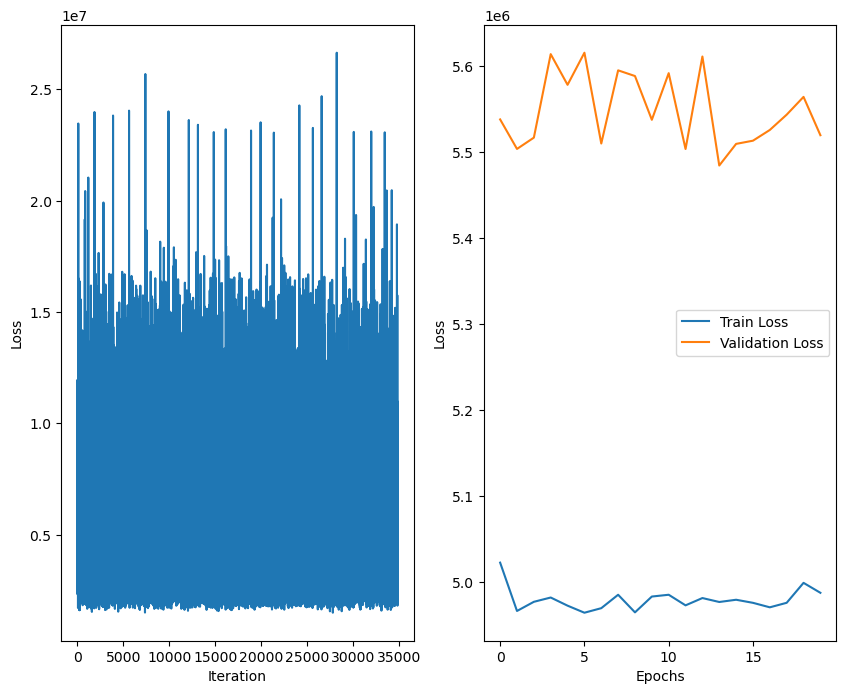

In [50]:
# visualization
fix,axes=plt.subplots(nrows=1,ncols=2,figsize=(10, 8))

axes[0].plot(range(N_epochs*N_batches),adam_batch_loss,label="adam_batch_loss")
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')

axes[1].plot(range(N_epochs),losses,label="Train Loss")
axes[1].plot(range(N_epochs),val_losses,label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [51]:
mybestmodel=myModel(x_train.shape[1],1)

if torch.cuda.is_available():
    mybestmodel=mybestmodel.cuda()
    
#load best model
mybestmodel.load_state_dict(torch.load(f"best_model_64_0.001"))

#calculate test accuracy
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
test_batch_loss=[]

for x_batch,y_batch in test_dataloader:
    if torch.cuda.is_available():
        x_batch=x_batch.cuda()
        y_batch=y_batch.cuda()
    y_pred=mybestmodel(x_batch)
    test_batch_loss.append(loss_fun(y_pred,y_batch).detach().cpu().numpy())

test_loss=np.sqrt(np.mean(np.array(test_batch_loss)))
print(f"Test rmse loss ={test_loss}")

Test rmse loss =6098054.5


### To do: grid search

## To do: CNN or other architectures